In [15]:
import numpy as np
import pandas as pd
import cdflib

from pyaw import utils

In [16]:
fp_b = r"D:\cleo\master\pyaw\data\Swarm\SW_MAGx_HR_1B\A\swarm_Level1b_Entire_mission_data_MAGx_HR_Sat_A_SW_OPER_MAGA_HR_1B_20160311T000000_20160311T235959_0602.CDF\SW_OPER_MAGA_HR_1B_20160311T000000_20160311T235959_0602_MDR_MAG_HR.cdf"
fp_e = r"D:\cleo\master\pyaw\data\Swarm\SW_EFIx_TCT16\A\SW_EXPT_EFIA_TCT16_20160311T000000_20160311T065505_0302.cdf"

In [17]:
def read_MAGx_HR_1B(fp):
    cdf_file = cdflib.CDF(fp)
    info = cdf_file.cdf_info()
    df = pd.DataFrame()
    for zVariable in info.zVariables:
        zVariable_data = cdf_file.varget(zVariable)
        if len(zVariable_data.shape) > 1:
            df[zVariable] = list(zVariable_data)
        else:
            df[zVariable] = zVariable_data
    return df


df_b = read_MAGx_HR_1B(fp_b)
df_e = read_MAGx_HR_1B(fp_e)

In [18]:
def get_datetime(timestamp):
    # Create a numpy datetime object for Year 0, January 1, and the unit is millisecond
    ad0_reference = np.datetime64('0000-01-01', 'ms')
    # Convert the 'Timestamp' to datetime by adding the milliseconds since the epoch_reference
    # Assuming 'Timestamp' is in milliseconds
    return ad0_reference + np.array(timestamp, dtype='timedelta64[ms]')


df_b['datetime'] = get_datetime(df_b['Timestamp'])
df_e['datetime'] = get_datetime(df_e['Timestamp'])

In [ ]:
# 384735 -1

In [19]:
df_e['datetime'].iloc[384735], df_e['datetime'].iloc[-1]

(Timestamp('2016-03-11 06:40:48.943000'),
 Timestamp('2016-03-11 06:55:05.943000'))

In [45]:
df_e_orbit = df_e[(df_e['datetime'] <= df_e['datetime'].iloc[397844]) & (df_e['datetime'] >= df_e['datetime'].iloc[384735])]
df_b_orbit = df_b[(df_b['datetime'] <= df_e['datetime'].iloc[397844]) & (df_b['datetime'] >= df_e['datetime'].iloc[384735])]

In [46]:
bn,be,bc = utils_preprocess.get_3arrs(df_b_orbit['B_NEC'].values)

In [47]:
datetimes_b = df_b_orbit['datetime'].values
datetimes_e = df_e_orbit['datetime'].values

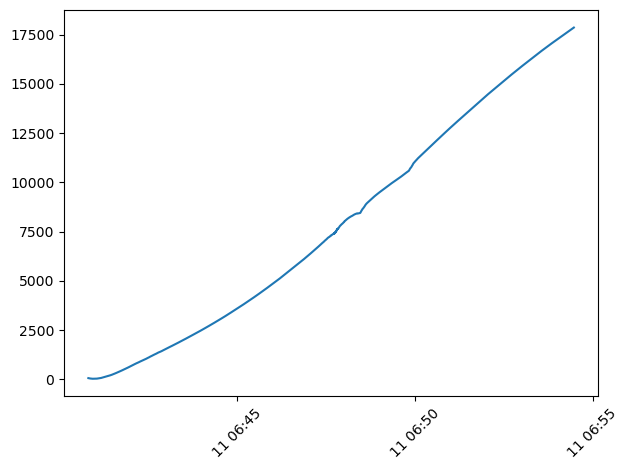

In [48]:
from matplotlib import pyplot as plt

plt.plot(datetimes_b, bn)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
Ehx = df_e_orbit['Ehx'].values
Ehy = df_e_orbit['Ehy'].values

VsatN = df_e_orbit['VsatN'].values
VsatE = df_e_orbit['VsatE'].values
rotation_matrix_2d_nec2sc, rotation_matrix_2d_sc2nec = utils_preprocess.get_rotmat_nec2sc_sc2nec(VsatN, VsatE)

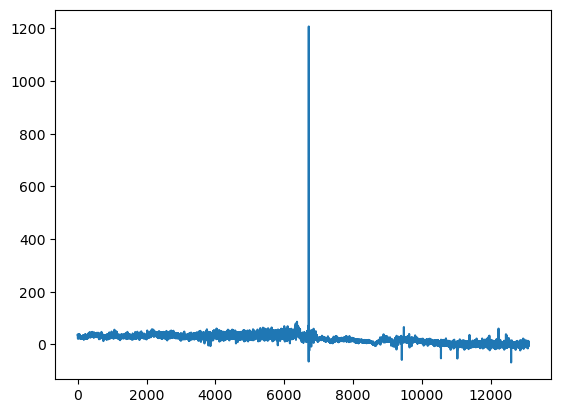

In [51]:
plt.plot(Ehy)

In [52]:
Ehx_set_outliers_nan = utils_preprocess.set_outliers_nan_std(Ehx,3, print_=True)
Ehy_set_outliers_nan = utils_preprocess.set_outliers_nan_std(Ehy,3, print_=True)

67
[  62.941044   88.83709    43.441505   65.35207    74.2946     66.23781
   97.228874  106.927414   63.76412    87.39157    77.586365   78.28989
   42.50732   -78.52971    91.285675  -45.058784   57.703865   46.417206
   51.466206  -78.7512    -43.9735     55.85131    96.95131   -52.246895
  -77.74769   122.04997   -50.420204  -52.979156  -57.540714   90.70911
   71.15288    56.372738   58.08169  -630.02313  -665.1797   -455.31207
  209.64946   125.68604   -39.010178  -40.798836  -40.506485  -39.24076
  -40.14813   -41.244125  -40.92059   -40.290085  -42.351627  -40.237312
  -38.676064  -38.770054  -39.570744  -44.64541   -40.207573  -43.83246
  -39.102108  -45.281628   57.414288   61.380596  -38.86531    42.93025
   44.9006     62.04238    49.27954    51.333736   49.008797   58.06297
   63.430603]
10
[  85.93454   -65.169945 1116.1362   1207.5975    117.2339     88.194145
  -58.97826   -52.955784  -53.812504  -68.791466]


In [53]:
Ehx_set_outliers_nan_interpolated = utils_preprocess.get_array_interpolated(datetimes_e, Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = utils_preprocess.get_array_interpolated(datetimes_e, Ehy_set_outliers_nan)

In [54]:
Ehn, Ehe = utils_preprocess.do_rotation(-Ehx_set_outliers_nan_interpolated, -Ehy_set_outliers_nan_interpolated,
                             rotation_matrix_2d_sc2nec)

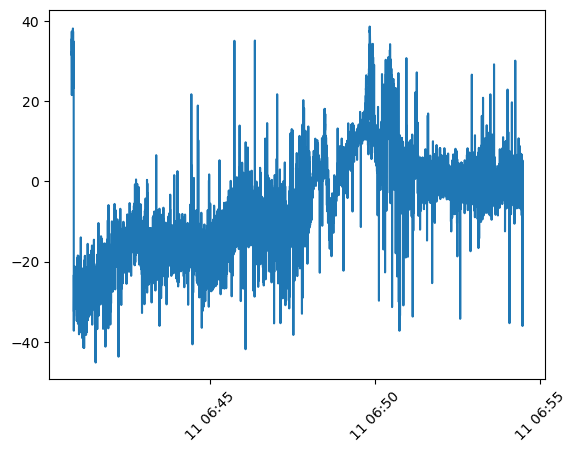

In [55]:
plt.plot(datetimes_e, Ehn)
plt.xticks(rotation=45)
plt.show()

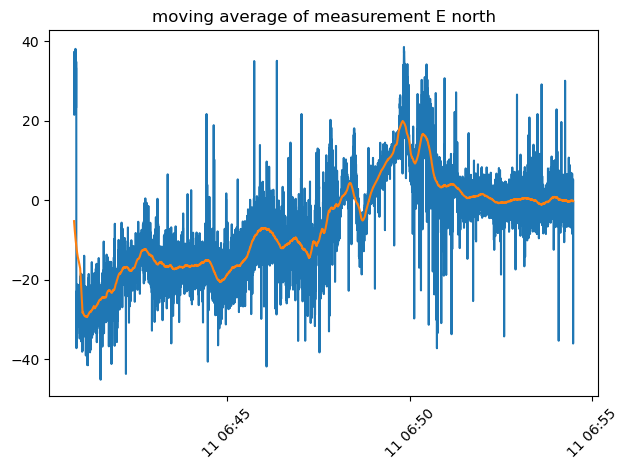

In [58]:
fs_e = 16
fs_b= 50
mv_window_seconds = 20  # int
window_e = fs_e * mv_window_seconds
Ehn_mov_ave = utils_preprocess.move_average(Ehn, window_e,min_periods=1)

plt.plot(datetimes_e, Ehn)
plt.plot(datetimes_e, Ehn_mov_ave)
plt.title("moving average of measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

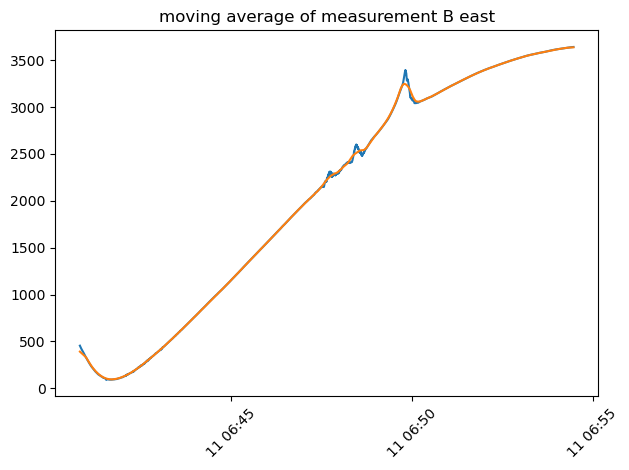

In [59]:
window_b = fs_b * mv_window_seconds
be_mov_ave = utils_preprocess.move_average(be, window_b,min_periods=1)

# plt.figure()
plt.plot(datetimes_b, be)
plt.plot(datetimes_b, be_mov_ave)
plt.title("moving average of measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f'before and after moving average comparison')

In [60]:
Ehn_disturb = Ehn - Ehn_mov_ave
be_disturb = be - be_mov_ave

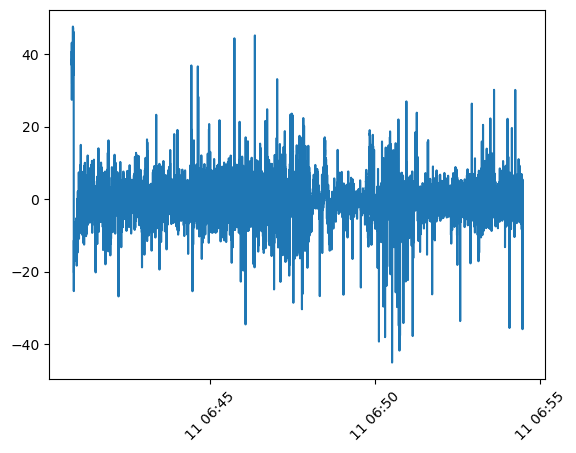

In [61]:
plt.plot(datetimes_e, Ehn_disturb)
plt.xticks(rotation=45)
plt.show()

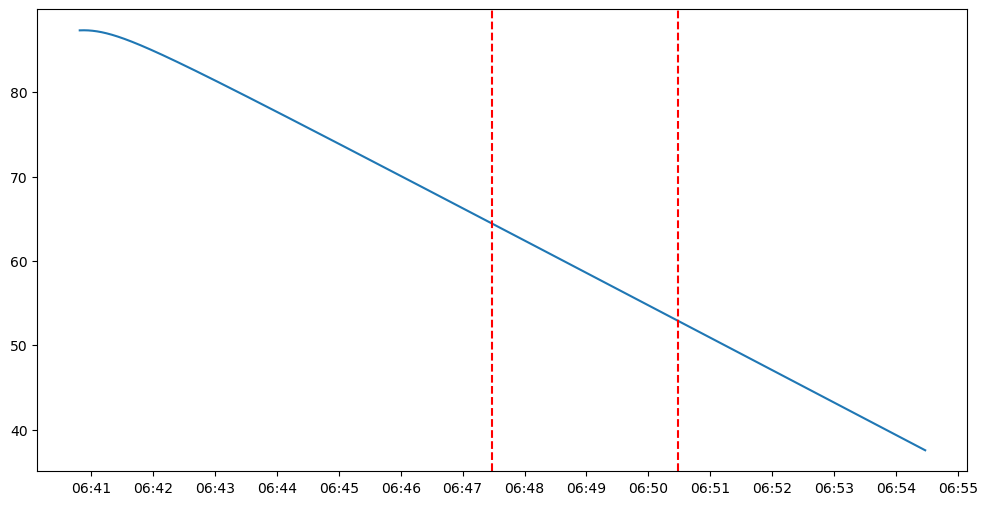

In [96]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(datetimes_b,df_b_orbit['Latitude'].values)
# 设置 x 轴日期格式和标注频率
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # 每 10 分钟一个标注
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 时间格式为 "小时:分钟"
plt.axvline(x=datetimes_b[20000], color='r', linestyle='--')
plt.axvline(x=datetimes_b[29000], color='r', linestyle='--')
plt.show()

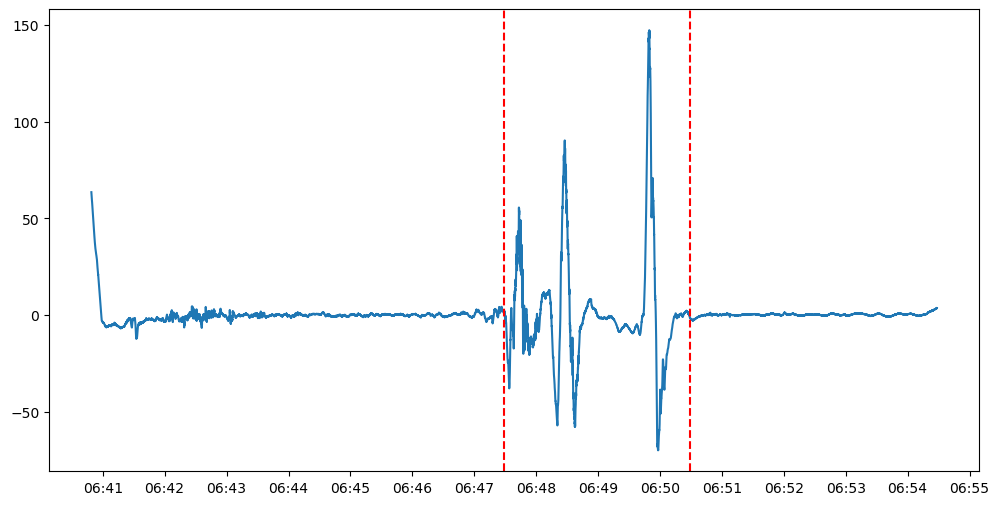

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(datetimes_b, be_disturb)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.axvline(x=datetimes_b[20000], color='r', linestyle='--')
plt.axvline(x=datetimes_b[29000], color='r', linestyle='--')
plt.show()

In [71]:
from scipy.signal import stft

# stft (spectral) basic parameters
window = 'hann'
stft_window_seconds = 4  # second
nperseg_e = int(stft_window_seconds * fs_e)  # 每个窗的采样点数
noverlap_e = nperseg_e // 2  # 50%重叠
nperseg_b = int(stft_window_seconds * fs_b)
noverlap_b = nperseg_b // 2

# get stft
f_e, t_e, Zxx_e = stft(Ehn_disturb, fs_e, window=window, nperseg=nperseg_e, noverlap=noverlap_e,
                       scaling='psd')
f_b, t_b, Zxx_b = stft(be_disturb, fs_b, window=window, nperseg=nperseg_b, noverlap=noverlap_b,
                       scaling='psd')

In [72]:
t_e_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in t_e]
t_b_dt64 = datetimes_b[0] + [np.timedelta64(int(_), 's') for _ in t_b]

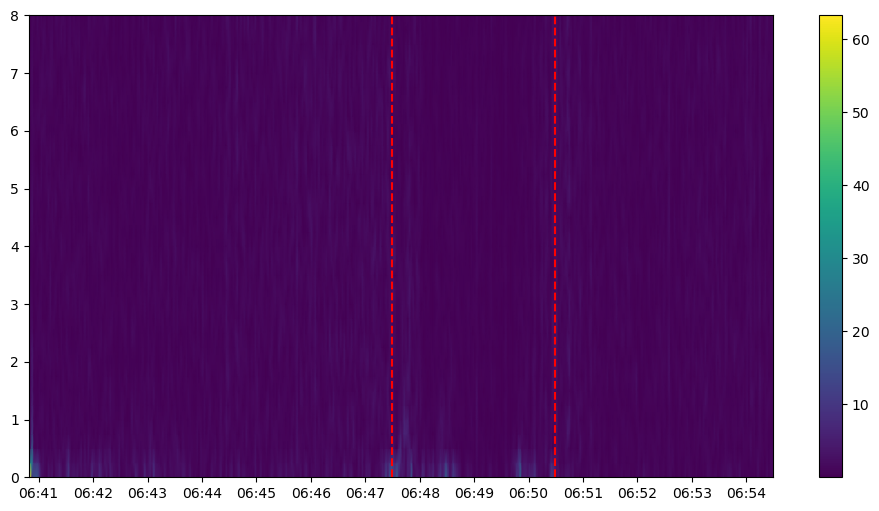

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.pcolormesh(t_e_dt64, f_e, np.abs(Zxx_e), shading='gouraud')
plt.colorbar()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.axvline(x=datetimes_b[20000], color='r', linestyle='--')
plt.axvline(x=datetimes_b[29000], color='r', linestyle='--')
plt.show()

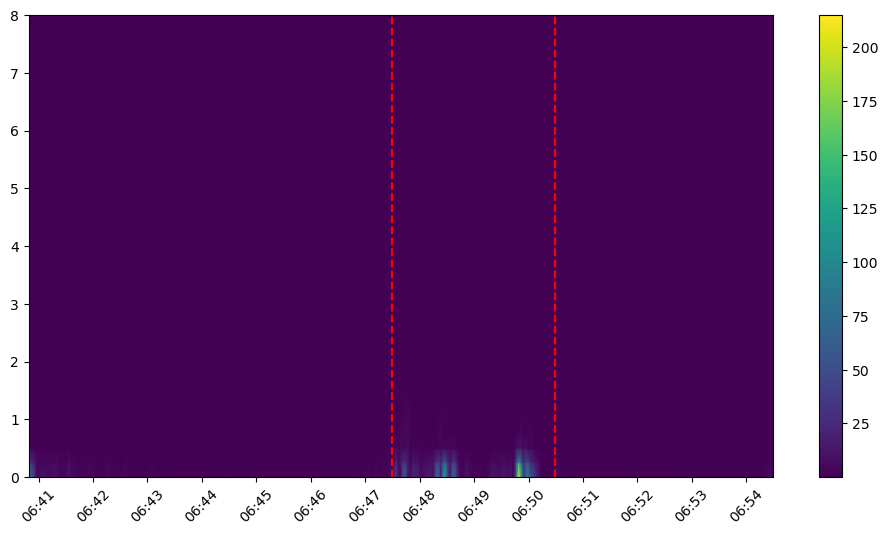

In [103]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.pcolormesh(t_b_dt64, f_b, np.abs(Zxx_b), shading='gouraud')
plt.ylim([0, 8])
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.axvline(x=datetimes_b[20000], color='r', linestyle='--')
plt.axvline(x=datetimes_b[29000], color='r', linestyle='--')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [77]:
mask_f_b = np.where(f_b <= 8.0)
f_b_mask = f_b[mask_f_b]
Zxx_b_mask = Zxx_b[mask_f_b]
np.all(t_e == t_b), np.all(t_e_dt64 == t_b_dt64), np.all(f_e == f_b_mask), Zxx_b_mask.shape == Zxx_e.shape

(True, False, True, True)

In [88]:
cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b_mask)

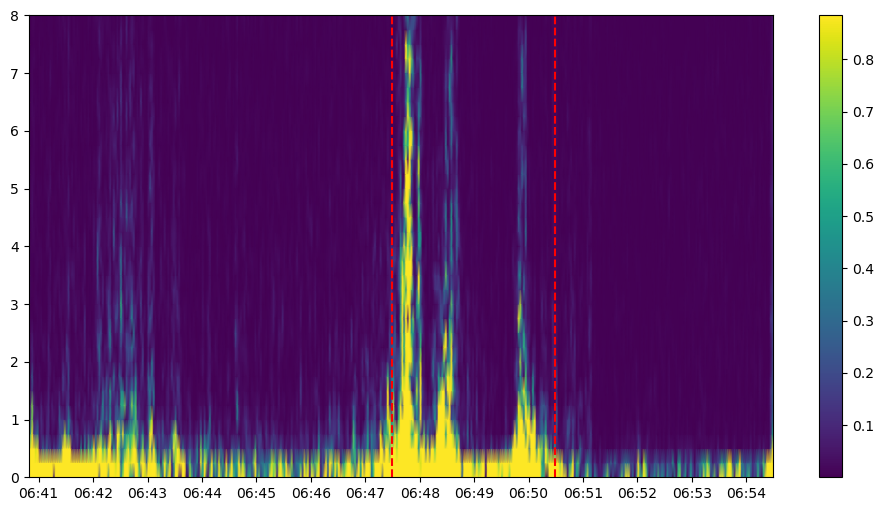

In [104]:
fig, ax = plt.subplots(figsize=(12, 6))
cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
modified_cross_e_b_spectral_density_module = utils_preprocess.threshold_and_set(cross_e_b_spectral_density_module.copy(),np.percentile(cross_e_b_spectral_density_module, 95),np.percentile(cross_e_b_spectral_density_module, 95))

plt.pcolormesh(t_e_dt64, f_e, modified_cross_e_b_spectral_density_module, shading='gouraud')
plt.colorbar()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.axvline(x=datetimes_b[20000], color='r', linestyle='--')
plt.axvline(x=datetimes_b[29000], color='r', linestyle='--')
plt.show()